In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = "/content/model.jpeg"
style_reference_image_path = "/content/mona_lisa.jpg"
# name of the generated image
result_prefix = "generated_image"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


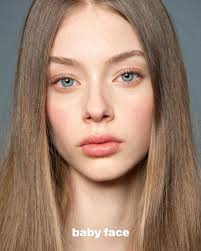

In [2]:
from IPython.display import Image, display

display(Image(base_image_path))


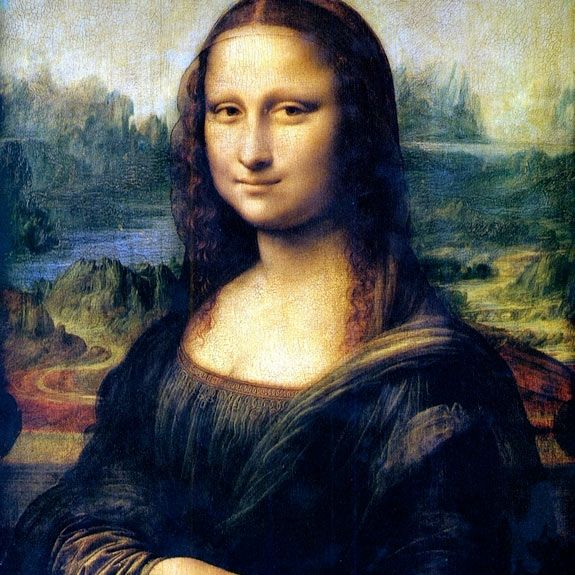

In [3]:
display(Image(style_reference_image_path))

## Image preprocessing / deprocessing utilities


In [4]:

def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x



In [5]:
# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))



In [6]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss



In [8]:

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads



In [9]:
import tensorflow as tf

# Check if GPU is being used
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


  2%|▏         | 999/50000 [02:16<1:49:01,  7.49it/s]

Iteration 1000: loss=1031.68


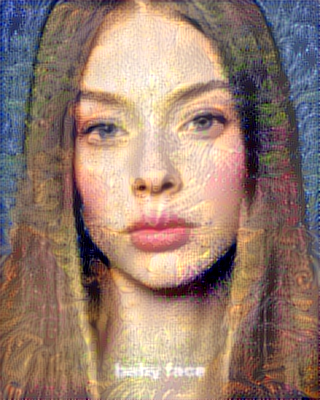

  4%|▍         | 1999/50000 [04:33<1:50:13,  7.26it/s]

Iteration 2000: loss=883.75


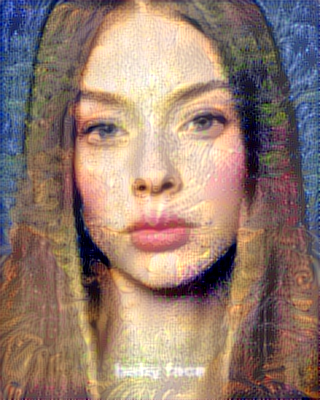

  6%|▌         | 2999/50000 [06:50<1:47:46,  7.27it/s]

Iteration 3000: loss=822.17


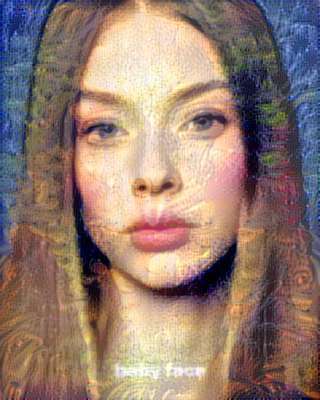

  8%|▊         | 3999/50000 [09:07<1:44:56,  7.31it/s]

Iteration 4000: loss=789.57


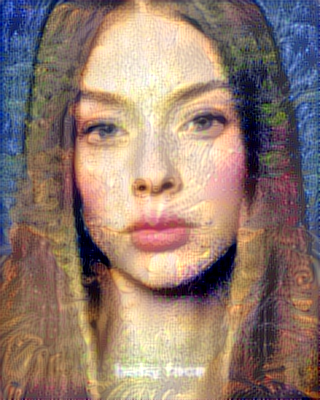

 10%|▉         | 4999/50000 [11:24<1:43:11,  7.27it/s]

Iteration 5000: loss=770.34


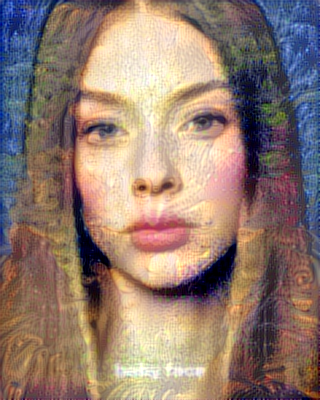

 12%|█▏        | 5999/50000 [13:41<1:40:12,  7.32it/s]

Iteration 6000: loss=758.43


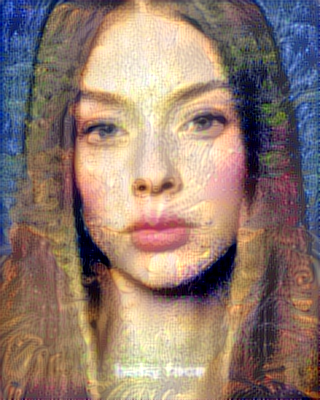

 14%|█▍        | 6999/50000 [15:58<1:38:00,  7.31it/s]

Iteration 7000: loss=750.89


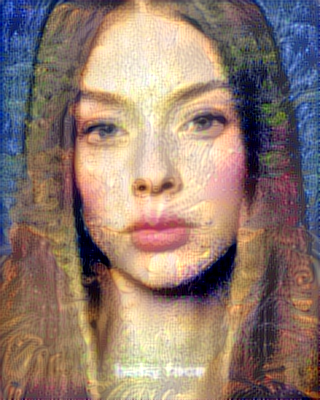

 16%|█▌        | 7999/50000 [18:15<1:36:03,  7.29it/s]

Iteration 8000: loss=746.03


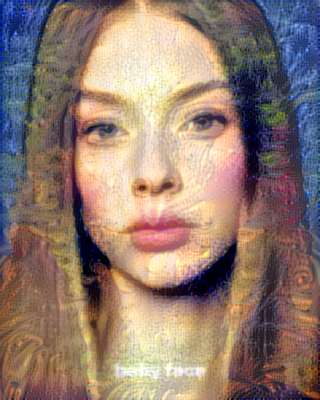

 18%|█▊        | 8999/50000 [20:32<1:33:19,  7.32it/s]

Iteration 9000: loss=742.86


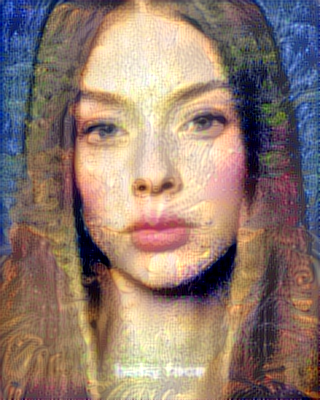

 20%|█▉        | 9999/50000 [22:49<1:31:18,  7.30it/s]

Iteration 10000: loss=740.78


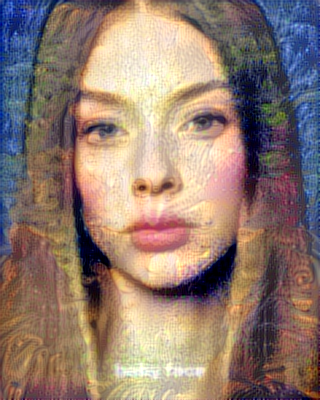

 22%|██▏       | 10999/50000 [25:06<1:29:04,  7.30it/s]

Iteration 11000: loss=739.41


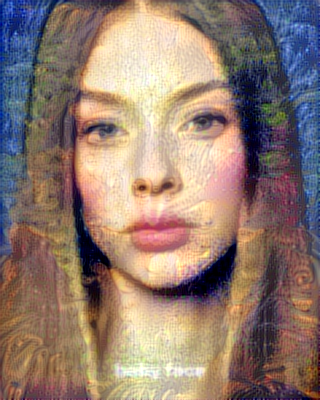

 24%|██▍       | 11999/50000 [27:23<1:26:39,  7.31it/s]

Iteration 12000: loss=738.50


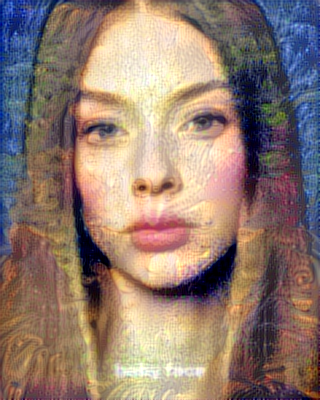

 26%|██▌       | 12999/50000 [29:40<1:24:20,  7.31it/s]

Iteration 13000: loss=737.90


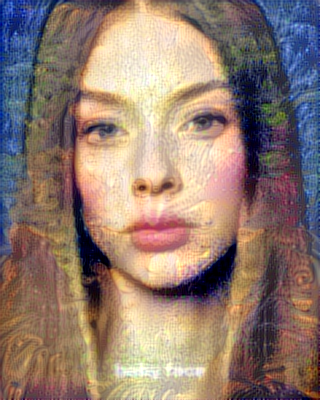

 28%|██▊       | 13999/50000 [31:56<1:22:00,  7.32it/s]

Iteration 14000: loss=737.51


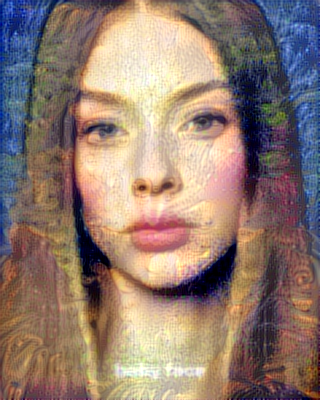

 30%|██▉       | 14999/50000 [34:13<1:19:52,  7.30it/s]

Iteration 15000: loss=737.24


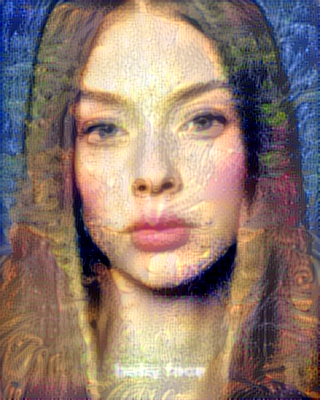

 32%|███▏      | 15999/50000 [36:30<1:17:40,  7.30it/s]

Iteration 16000: loss=737.07


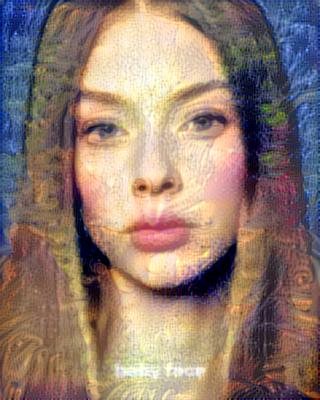

 34%|███▍      | 16999/50000 [38:47<1:15:00,  7.33it/s]

Iteration 17000: loss=736.95


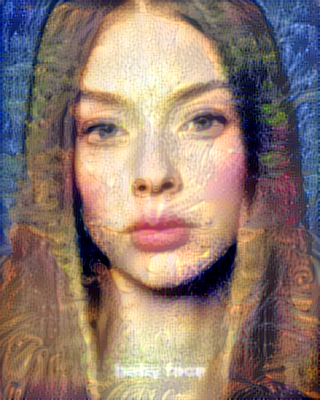

 36%|███▌      | 17999/50000 [41:04<1:13:06,  7.30it/s]

Iteration 18000: loss=736.88


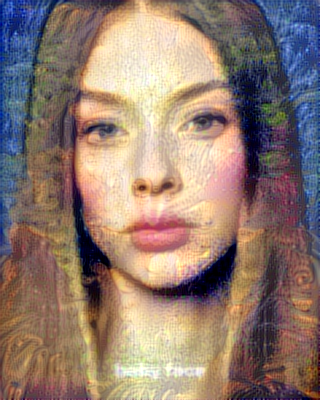

 38%|███▊      | 18999/50000 [43:21<1:10:42,  7.31it/s]

Iteration 19000: loss=736.83


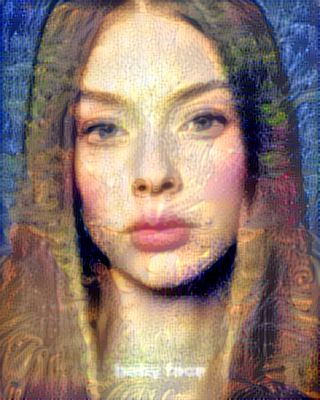

 40%|███▉      | 19999/50000 [45:38<1:08:35,  7.29it/s]

Iteration 20000: loss=736.80


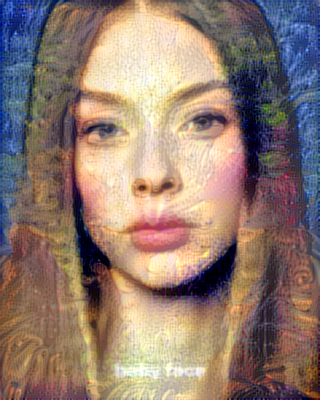

 42%|████▏     | 20999/50000 [47:56<1:06:07,  7.31it/s]

Iteration 21000: loss=736.79


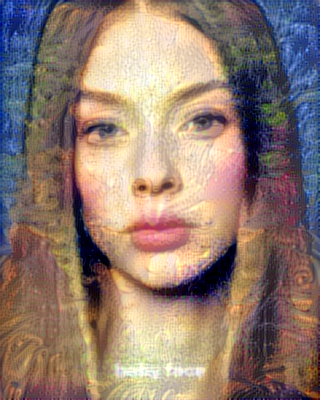

 44%|████▍     | 21999/50000 [50:13<1:03:57,  7.30it/s]

Iteration 22000: loss=736.78


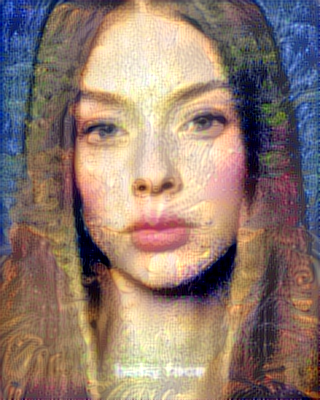

 46%|████▌     | 22999/50000 [52:29<1:01:33,  7.31it/s]

Iteration 23000: loss=736.78


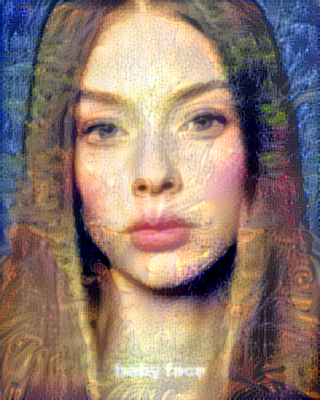

 48%|████▊     | 23999/50000 [54:46<59:08,  7.33it/s]

Iteration 24000: loss=736.78


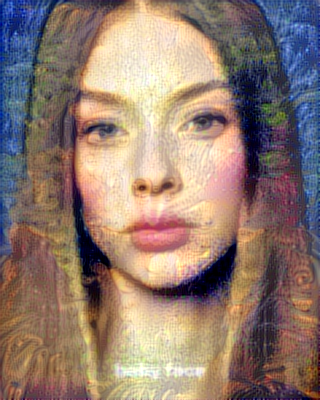

 50%|████▉     | 24837/50000 [56:41<57:26,  7.30it/s]


KeyboardInterrupt: 

In [10]:
from tqdm import tqdm

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 50000
for i in tqdm(range(1, iterations + 1)):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])

    # save image after every 1000 steps
    if i % 1000 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)
        display(Image(fname))
